In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import Array
import jax
import numpy as np

In [3]:
from jax.config import config
config.update("jax_debug_nans", True)
config.update("jax_array", True)

In [4]:
%matplotlib ipympl
import matplotlib.pyplot as plt

In [5]:
def init_layer(key, in_features: int, out_features: int):
    w_key, b_key = random.split(key)
    bound = np.sqrt(1 / in_features)
    weight = random.uniform(w_key, (out_features, in_features), -bound, bound)
    bias = random.uniform(b_key, (out_features, ), -bound, bound)
    return weight, bias

def init_network(key, sizes):
    n = len(sizes)
    key, *layer_keys = random.split(key, num=n)
    network = []
    for i in jnp.arange(n - 1):
        layer = init_layer(layer_keys[i], sizes[i], sizes[i + 1])
        network.append(layer)
    return network

key = random.PRNGKey(0)
key, subkey = random.split(key)
network = init_network(subkey, [10, 5, 5, 10])
for x in network:
    print(x[0].shape)

(5, 10)
(5, 5)
(10, 5)


In [6]:
def sigmoid(x: Array):
    return 0.5 * (jnp.tanh(x / 2) + 1)

def relu(x: Array):
    return jnp.maximum(0, x)

def predict(network, activation, x):
    for weight, bias in network:
        x = activation(jnp.dot(weight, x) + bias)
    return x

t = 3
x = jnp.eye(3)
xt = jnp.append(x.flatten(), t)
# predict(network, relu, xt)

In [7]:
from functools import partial

In [8]:
@partial(jit, static_argnames=['t'])
def forward_diffuse(key, x: Array, t: int, var_schedule: Array):
    shape = x.shape
    x = x.flatten()
    alpha = jnp.prod((1 - var_schedule)[:t])
    mean = jnp.dot(jnp.sqrt(alpha), x).flatten()
    cov = jnp.dot((1 - alpha), jnp.eye(x.shape[0]))
    x = random.multivariate_normal(key, mean, cov)
    return x.reshape(shape)

def reverse_diffuse_with(mean_fn):
    @partial(jit, static_argnames=['t'])
    def _reverse_diffuse(key, x: Array, t: int, var_schedule: Array):
        shape = x.shape
        x = x.flatten()
        for t in jnp.flip(jnp.arange(t)):
            mean = mean_fn(x, t)
            cov = jnp.dot(var_schedule[t], jnp.eye(x.shape[0]))
            x = random.multivariate_normal(key, mean, cov)
        return x.reshape(shape)
    return _reverse_diffuse

# example usage of reverse_diffuse_with
reverse_diffuse = reverse_diffuse_with(lambda x, t: x)

# %timeit forward_diffuse(random.PRNGKey(0), jnp.eye(3), 3, jnp.array([0.1, 0.1, 0.1]))
# %timeit reverse_diffuse(random.PRNGKey(0), jnp.eye(3), 3, jnp.array([0.1, 0.1, 0.1]))

In [9]:
# for visualizing forward and reverse diffusion
n = 4
x = jnp.eye(3)
var_schedule = jnp.array([0.1, 0.2, 0.5])

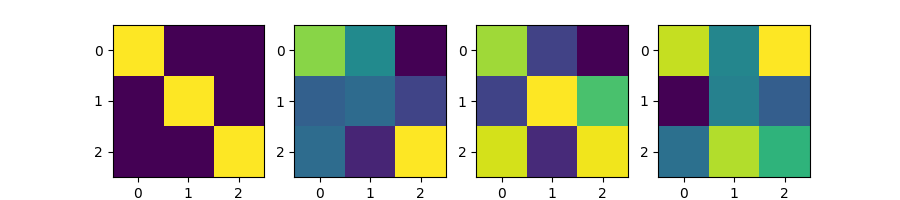

In [10]:
# forward diffusion
_, axs = plt.subplots(nrows=1, ncols=n, figsize=(9, 2))
axs[0].imshow(x)
for t in jnp.arange(1, n):
    key, subkey = random.split(key)
    state = forward_diffuse(subkey, x, int(t), var_schedule)
    axs[t].imshow(state)

In [11]:
print(state)
plt.close()

[[ 1.0642747  -0.12637758  1.298029  ]
 [-1.3350767  -0.18219376 -0.5478018 ]
 [-0.36402634  0.9984135   0.38147372]]


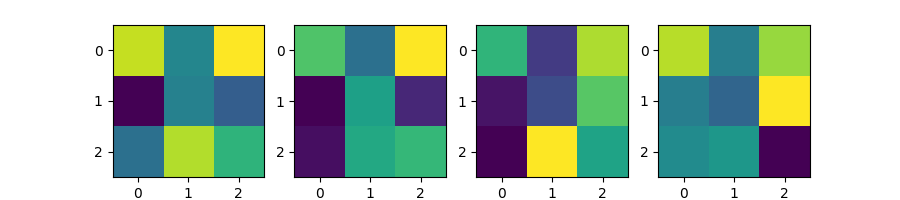

In [12]:
# reverse diffusion
x = state
_, axs = plt.subplots(nrows=1, ncols=n, figsize=(9, 2))
axs[0].imshow(x)
for t in jnp.arange(1, n):
    key, subkey = random.split(key)
    axs[t].imshow(reverse_diffuse(subkey, x, int(t), var_schedule))

In [66]:
@jit
def mse_loss(output: Array, target: Array):
    D = jnp.prod(jnp.array(target.shape))
    error = (target - output)
    return jnp.sum((error).dot(error)) / D

@partial(jit, static_argnames=['t'])
def target_fn(x_init: Array, x: Array, t: int, var_schedule: Array):
    """
    Given (flattened) x_init and x at t, compute the target mean
    and target covariance.
    """
    eps = 1e-6
    beta_t = var_schedule[t-1]
    alpha = jnp.prod((1 - var_schedule)[:t-1])
    alpha_t = jnp.dot(alpha, 1 - beta_t)
    denom = 1 - alpha_t

    mean_init = jnp.dot(jnp.sqrt(alpha) * beta_t / denom, x_init)
    mean_t = jnp.dot(jnp.sqrt(alpha_t) * (1 - alpha) / denom, x)

    target_mean = mean_init + mean_t
    target_cov = jnp.dot((1 - alpha) / denom, jnp.eye(x.shape[0])) + eps

    return target_mean, target_cov

def kl_divergence_with(output_mean_fn):
    """
    Wrapper to take in the output mean function approximator.
    output_mean_fn should take in the (flattened) state x and timestep t,
    and compute the output mean.
    """
    @partial(jit, static_argnames=['t'])
    def _kl_divergence(x_init: Array, x: Array, t: int, var_schedule: Array):
        x_init = x_init.flatten()
        x = x.flatten()

        output_mean = output_mean_fn(x, t)
        output_cov = jnp.dot(var_schedule[t-1], jnp.eye(x.shape[0]))
        output_logvar = jnp.log(jnp.diag(output_cov))

        target_mean, target_cov = target_fn(x_init, x, t, var_schedule)
        target_logvar = jnp.log(jnp.diag(target_cov))

        logvar = output_logvar - target_logvar + jnp.exp(target_logvar - output_logvar)
        mean = jnp.square(target_mean - output_mean) * jnp.exp(-output_logvar)
        return jnp.mean(0.5 * (-1.0 + logvar + mean)) / jnp.log(2.0)
    return _kl_divergence

In [67]:
kl_divergence = kl_divergence_with(lambda x, t: x)
kl_divergence(jnp.zeros((3, 3)), jnp.ones((3, 3)), 3, jnp.array([0.5, 0.5, 0.5]))

Array(0.82722723, dtype=float32)

In [68]:
# setup for training
def model_fns(model):
    def output_mean_fn(x, t):
        return predict(model, relu, jnp.append(x, t))
    reverse_diffuse = reverse_diffuse_with(output_mean_fn)
    kl_divergence = kl_divergence_with(output_mean_fn)
    return output_mean_fn, reverse_diffuse, kl_divergence

def loss(key, model, x_init, max_timestep, mse_weight, kl_weight, var_schedule):
    _, reverse_diffuse, kl_divergence = model_fns(model)

    key, *subkeys = random.split(key, num=4)
    t = int(random.uniform(subkeys[0], minval=1, maxval=max_timestep))
    x_t = forward_diffuse(subkeys[1], x_init, t, var_schedule)
    x_hat = reverse_diffuse(subkeys[2], x_t, t, var_schedule)

    mse = mse_loss(x_hat, x_init)
    kl = kl_divergence(x_init, x_t, t, var_schedule)
    # print(mse, kl)
    return mse_weight * mse + kl_weight * kl

def update(key, model, x, max_timestep, mse_weight, kl_weight, step_size, var_schedule):
    # run gradients from loss through model parameters
    grads = grad(loss, argnums=1)(key, model, x, max_timestep, mse_weight, kl_weight, var_schedule)

    # loss(key, model, x, max_timestep, mse_weight, kl_weight)

    # take a gradient step
    step = [(w - step_size * dw, b - step_size * db) for (w, b), (dw, db) in zip(model, grads)]
    # print(step)
    return step

In [69]:
key = random.PRNGKey(0)

# hyperparameters to be changed
var_schedule = jnp.array([1e-6] * 5)
mse_weight = 0.0

# these variables depend on the previous ones
# and so do not need to be explicitly changed
max_timestep = var_schedule.shape[0] + 1
kl_weight = 1 - mse_weight

# the following model looks like:
# [ (w1, b1), (w2, b2) ]
# where
# layer 1: input 10, output 4
# layer 2: input 4, output 9
model = init_network(subkey, [10, 4, 9])
original_model = model

In [82]:
# training loop
import time
from tqdm import tqdm

# training_data = [jnp.eye(3)]
x_init = jnp.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
step_size = 0.5

num_epochs = 100 # 1000
total_time = 0.0
for epoch in tqdm(range(num_epochs)):
    start_time = time.time()

    # for x_init in training_data:
    key, subkey = random.split(key)
    model = update(subkey, model, x_init, max_timestep, mse_weight, kl_weight, step_size, var_schedule)
    # print(mse_loss(x_hat, x_init))

    epoch_time = time.time() - start_time
    total_time += epoch_time
    # print(f"Epoch {epoch} took {epoch_time} sec")

print(f"Training took {total_time} seconds in total")

# print()
# print(model)

100%|██████████| 100/100 [00:33<00:00,  2.96it/s]

Training took 33.79042935371399 seconds in total


Sampled timesteps t: 1
Loss results:
mse: 0.11122234910726547, kl: 78062.7890625


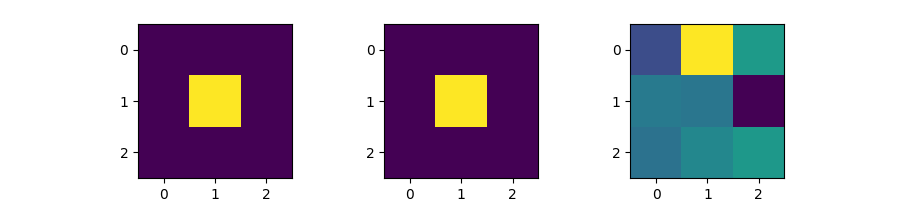

In [83]:
# change the seed to something else if you want different results
seed = 0
key = random.PRNGKey(seed)

output_mean_fn, reverse_diffuse, kl_divergence = model_fns(model)
key, *subkeys = random.split(key, num=4)
t = int(random.uniform(subkeys[0], minval=1, maxval=max_timestep))
print(f"Sampled timesteps t: {t}")

# choose the starting matrix that we want to learn
# note: size of x_init depends on the size of the model
# model's initial input size (in_features) is:
# size of FLATTENED x_init + 1 (since we append t at the end)
x_init = jnp.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
# x_init = jnp.eye(3)
# x_init = random.multivariate_normal(subkey, jnp.zeros(49), jnp.eye(49)).reshape((7, 7))

# run the forward and learned reverse process
x_t = forward_diffuse(subkeys[1], x_init, t, var_schedule)
x_hat = reverse_diffuse(subkeys[2], x_t, t, var_schedule)

mse = mse_loss(x_hat, x_init)
kl = kl_divergence(x_init, x_t, t, var_schedule)
print(f"Loss results:\nmse: {mse}, kl: {kl}")

# change n if you want to add more subplots to the plot
n = 3

_, axs = plt.subplots(nrows=1, ncols=n, figsize=(9, 2))
# plot matrices from left to right
axs[0].imshow(x_init)
axs[1].imshow(x_t)
axs[2].imshow(x_hat)

In [48]:
# run this every so often if there are too many plots open
# "Figure x" means there are x plots open
# the notebook might complain once x >= 20
for _ in jnp.arange(30):
    plt.close()